# TA Discussion - CAPM

## Brian Wickman

In [ ]:
# Load required packages
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

### (1) CAPM Introduction

Mean-variance optimization provides a framework for constructing optimal portfolios given the expected returns and covariances of assets. Thus far, we have used the average historical return to proxy expected returns, but is this really our best guess? Now, we introduce asset pricing models to improve our guess at the first moment, starting with one of the most influential models in finance, the CAPM.

The CAPM states that expected return is a linear function of a single source of risk:

$$
\mathbb{E}[\tilde{r}^i] = \beta^{i,m}\mathbb{E}[\tilde{r}^m]
$$

and equivalently,

$$
(\text{exposure to risk premium}) \times (\text{risk premium})
$$

where

$$
\beta^{i,m} = \frac{\text{cov}(\tilde{r}^i, \tilde{r}^m)}{\text{var}(\tilde{r}^m)}
$$

where $\tilde{r}^i$ is the (excess) return of asset $i$ and $\tilde{r}^m$ is the (excess) return of the market portfolio. In plain english, **the expected return of asset $i$ is a linear function of the expected return of the market portfolio, scaled by asset $i$'s co-movement with the market portfolio**.

#### What is MSFT's expected excess return in 2025?

If MSFT has a beta of 1.2 and the expected excess return of the market portfolio is 8%, then MSFT's expected excess return is:
   $$\mathbb{E}\left[\tilde{r}^{MSFT}\right] = 1.2 \times 8\% = 9.6\%$$

**Why is CAPM called a pricing model if it predicts excess return?**

We can easily translate between return and price. Remember, this is an estimate of the mean, i.e. a probabilistic forecast of the price.
$$\mathbb{E}\left[\tilde{r}^i\right] \iff \mathbb{E}\left[P^i\right]$$

Daily return to compound annually to 9.600000%: 0.035128%


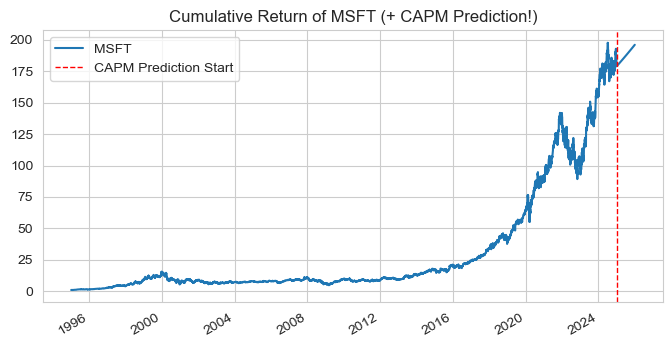

In [ ]:
# MSFT mean price forecast w/ CAPM
msft = pd.read_csv("data/msft.csv").set_index('date')
msft.index = pd.to_datetime(msft.index)

# Break annual estimated return to daily (such that daily compound to 9.6%)
# 1. Calc daily return: (1+E(r_daily))^261 - 1 = E[r_annual] -> E[r_daily] = 0.000351277
ANNUAL_RET = 0.096
daily_ret = float((1 + ANNUAL_RET) ** (1 / 261) - 1)
print(f"Daily return to compound annually to {ANNUAL_RET:%}: {daily_ret:2%}")

# 2. Generate sequence of 2025 trading days
trad_days_2025 = pd.bdate_range(start='2025-01-01', end='2025-12-31') # 261 trading days in 2025 lol
msft_2025 = pd.Series(data = [daily_ret] * len(trad_days_2025), index = trad_days_2025, name = 'MSFT')
#print(msft_2025.head())

# 3. Add CAPM prediction to cumulative return plot
msft_ret_full = pd.concat([msft, msft_2025]).sort_index()
msft_full_cum_ret = (msft_ret_full + 1).cumprod()
ax = msft_full_cum_ret.plot(figsize=(8, 4), title='Cumulative Return of MSFT (+ CAPM Prediction!)')
ax.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', linewidth=1, label='CAPM Prediction Start')
ax.legend(); plt.show()

### (2) Details

Note that the CAPM takes the expected return of the market and risk-free rate as inputs. Thus, it is a relative pricing formula (relative to the inputs)...

* What is the market portfolio? We've seen it before...
    * The market portfolio is a value-weighted portfolio of **all** (not just equities) available assets, including the non-traded and illiquid. In practice, a broad equity index like SPY is used. *Aside: How to determine the price of a non-traded asset?*
    * The market portfolio is actually the tangency portfolio from mean-variance optimization! Markowitz (1959) framed the portfolio optimization problem as a trade-off between expected return and variance of return. Sharpe (1964) and Litner (1965) derivations of CAPM showed that- in the absence of market frictions- if investors can agree on expected returns, volatilities and hold mean-variance efficient portfolios, then the market portfolio will itself be mean-variance efficient (no assumption that returns are normally distributed!).
    * *Roll critique: Most empirical tests only reject the CAPM because a proxy for the market portfolio is used. Kandel, Stambaug, and Shanken show that as long as the correlation between the proxy and the true market portfolio is at least 0.7, then the rejections are justified.*
* Interpreting $\beta$
    * The coefficient $\beta^{i,m}$ (often referred to as market beta) measures the covariance between asset $i$ and the market portfolio $m$. The stronger the co-movement, the higher the beta and the higher the expected return.
        * $\beta = 1$ means the asset moves in line with the market portfolio.
        * $\beta \geq 1$ means the asset is more volatile than the market portfolio (i.e., amplifies market movements).
        * $0< \beta < 1$ means the asset is less volatile than the market portfolio (i.e., dampens market movements).
    * We estimate $\beta$ from a regression (more on this later).
* Implications of CAPM
    * CAPM states that market risk is the **only** risk associated with higher expected returns (other metrics like vol, skewness, other covariances not associated with higher return).
* Single-period model
    * CAPM is a single-period, cross-sectional model. Equation (1.1) does not have a time subscripts. If you make the assumptions that returns are IID between periods and jointly multivariate normal, then the CAPM can hold period-by-period, acting like a multi-period model. (*Aside: An important (and recurring) property of the MV-normal distribution is that the conditional distribution of any subset of variables, given the values of another subset, is also MV-normal.*)

## *Sample Midterm \#2 Question*

What does it mean for the CAPM beta to be negative?

1. The asset is riskier than the market and amplifies market movements
2. The asset moves in the same direction as the market but with less volatility
3. The asset tends to move in the opposite direction of the market
4. The asset has no correlation with the market and provides pure diversification

### (3) CAPM and Risk Premia

Let's look at the CAPM equation in depth:

$$
\tilde{r}^i = \beta^{i,m}\tilde{r}^m + \varepsilon^i 
$$

$$
\mathbb{E}[\tilde{r}^i] = \beta^{i,m}\mathbb{E}[\tilde{r}^m] 
$$

$$
\text{var}(\tilde{r}^i) = (\beta^{i,m})^2\text{var}(\tilde{r}^m) + \text{var}(\varepsilon^i)
$$

$$
= (\text{systematic risk}) + (\text{idiosyncratic risk})
$$

For the variance, recall $\text{Var}(aX)=a^2\text{Var}(X), \, \text{for } a\in\mathbb{R}$.
* Define **risk premium of an asset** as the expected excess return of that asset over the risk-free rate.
* CAPM states that the risk premium of an asset is proportional to the market risk premium (also called *equity risk premium*).
* **The only risk associated with higher expected returns is exposure to the market portfolio.**
   * But we can be even more specific! Since the market portfolio is mean-variance efficient (idiosyncratic risk can be diversified away), only exposure to systematic risk is priced!

**Investors should expect no additional compensation/ return for bearing idiosyncratic risk.**

## *Sample Midterm \#2 Question2*

Which of the following two stocks has the higher expected return according to the CAPM?
| | AI Chip Manufacturer            | Public Utility        |
|----------------|--------------------|-----------------|
| Average Return | 15%                | 5%              |
| Volatility     | 35%                | 10%             |
| Value at Risk (VaR) | -0.1           | -0.03           |

### (4) CAPM and Sharpe Ratios
Let's see what the CAPM has to say about Sharpe Ratios (recall $SR = \tilde{r}^i/\sigma^i$):

$$
\mathbb{E}[\tilde{r}^i] = \beta^{i,m}\mathbb{E}[\tilde{r}^m]
$$

$$
= \left(\frac{\text{cov}(\tilde{r}^i, \tilde{r}^m)}{\text{var}(\tilde{r}^m)}\right)\mathbb{E}[\tilde{r}^m]
$$

$$
= \left(\frac{\rho^{i,m}\sigma_i\sigma_m}{\sigma_m^2}\right)\mathbb{E}[\tilde{r}^m]
$$

$$
= \rho^{i,m}\left(\frac{\sigma_i}{\sigma_m}\right)\mathbb{E}[\tilde{r}^m]
$$

$$
\frac{\mathbb{E}[\tilde{r}^i]}{\sigma_i} = \rho^{i,m}\left(\frac{\mathbb{E}[\tilde{r}^m]}{\sigma_m}\right)
$$

$$
SR_i = \rho^{i,m} SR_m
$$

**The Sharpe Ratio of asset $i$ is proportional to the Sharpe Ratio of the market portfolio, scaled by the correlation between asset $i$ and the market portfolio.**

* Implications:
   * No asset can have a Sharpe Ratio higher than the market portfolio (since $|\rho^{i,m}|\leq 1$)
      * We already knew that the tangency portfolio had the highest Sharpe Ratio!
   * **Assets with large idiosyncratic risk (low correlation with the market) will have low Sharpe Ratios.**

### (5) Taking the CAPM to Data

**Now that we have a pricing model (equivalently: a data generating process for returns), how can we test it's effectiveness in pricing assets?**

#### (5.1) Time-Series Test of the CAPM: Estimating Betas

CAPM implies that realized returns are generated by the following process:
    \begin{align}
        \tilde{r}^i_t &= \beta^{i,m}\tilde{r}^m_t + \varepsilon^i_t \tag{CAPM realized returns}
    \end{align}
with the assumption that $\mathbb{E}[\varepsilon^i_t] = 0$ and $\text{cov}(\varepsilon^i_t, \tilde{r}^m_t) = 0$ (idiosyncratic shocks are uncorrelated with market returns). **Observe that there is no intercept!**

For any asset $i$, run a time-series regression of excess returns $i$ on the excess market return to estimate $\alpha^i$ and $\beta^{i,m}$:
   $$r^i_t = \alpha^i + \beta^{i,m} r^m_t + \varepsilon^i_t \tag{5.1}$$
CAPM implies $\alpha^i = 0$ for all assets $i$. Thus, we can test the CAPM by testing whether the intercepts are statistically different from zero. If we use a group of assets (fit many regressions), the CAPM claims that every single $\alpha^i = 0$, which must be tested jointly (*statistical dangers of testing myltiple hypotheses [(link)](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)*). Sometimes, we can pool assets together and run a panel regression to increase statistical power (decrease idiosyncratic risk).

**A non-zero intercept represents the expected excess return of asset $i$ when the equity risk premium equals zero, suggesting additional (persistent) risk premia (sources of excess return).**

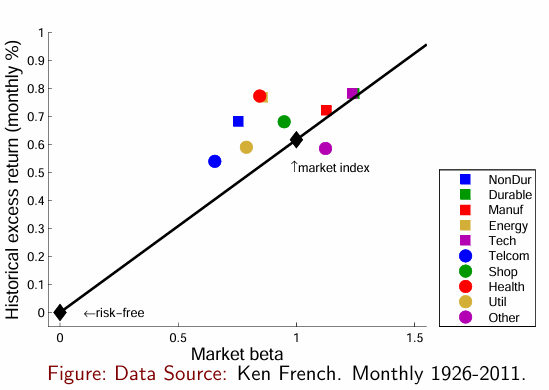

In [ ]:
display(Image(filename="pictures/capm_ts_industry_buckets.png"))

#### (5.2) Cross-Sectional Test of the CAPM

**Another view of CAPM is that it implies a linear relation between expected returns and market betas that perfectly explains the cross section of expected returns.** We can separate the CAPM into two steps:

$$
\mathbb{E}[\tilde{r}^i] = \beta^{i,m}\lambda_m
$$

$$
\lambda_m = \mathbb{E}[\tilde{r}^m]
$$

where **$\lambda_m$ is the amount of risk premium an asset gets per unit of market beta or the price of risk!**.

The cross-sectional test of the CAPM tests whether the expected returns of assets are proportional to their market betas. The test proceeds in two steps:
1. Estimate each asset's market beta $\beta^{i,m}$ from a time-series regression of excess returns on excess market returns (equation 5.1). **Assume these betas are known and treat them as exogenous.**
    1. *Potential drawback: introduces error-in-variables complication if beta's have measurement error. (Fama & MacBeth, 1987) overcome this by grouping stocks into industry portfolios, thus limiting the idiosyncratic noise and increasing the precision of beta estimates*
2. Run a cross-sectional regression of average excess returns on estimated market betas:
   
$$
\mathbb{E}[\tilde{r}^i] = \eta + \hat{\beta}^{i,m}\lambda_m + \nu^i
$$

$$
= (\text{intercept}) + \hat{\beta}^{i,m} \times (\text{slope}) + (\text{residual})
$$

3. Notes
    1. The cross-sectional regression estimates the intercept $\eta$ and slope $\lambda_m$, not the market betas.
    2. This is not a time-series regression (no $t$ subscripts).
4. CAPM Predictions:
    1. Equation (5.2) implies $R^2 = 0 \iff \nu^i = 0, \forall i$. Average returns for each asset $i$ are fully explained by market betas.
    2. Equation (5.3) implies $\eta = 0$ and $\lambda_m = \mathbb{E}\left[\tilde{r}^m \right]$. The market price of risk is equal to the expected excess return of the market portfolio.

In practice, the CAPM performs poorly in cross-sectional tests; (1) SML slope ($\lambda_m$) too small and (2) SML doesn't start at zero ($\eta >0$). A smaller slope implies that there is little difference in mean excess return even as risk $(\beta^{i,m})$ varies, so avoid high $\beta$ assets! For a very interesting paper, see [Frazzini and Pederson (2014)](https://pages.stern.nyu.edu/%7Elpederse/papers/BettingAgainstBeta.pdf) .

Here's a nice visual representation from Fama and French (1992), with the SML as the red-dashed line.:

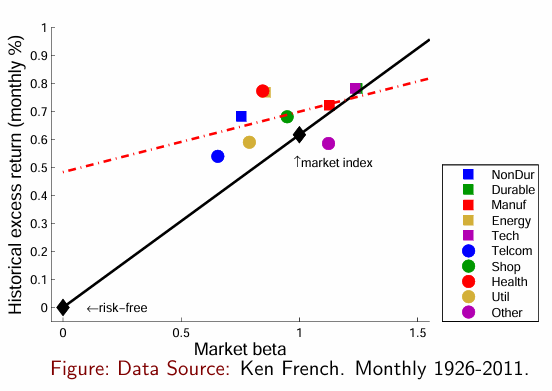

In [ ]:
display(Image(filename="pictures/capm_cs_buckets.png"))

#### (5.3) Empirical Summary

If the CAPM were completely accurate:
| | Intercept           | $R^2$      | $\varepsilon^i$  |  $\lambda_m$ (Price of risk) |
|----------------|--------------------|-----------------|---------|-----|
| Time Series | 0    |            | | |
| Cross-Sectional | 0 |  1          | 0 | $\mathbb{E}\left[\tilde{r}^m\right]$ |

### (6) Example: Applying CAPM
There are three parameters we need to estimate to use CAPM to predict returns
1. Expected market return
2. Asset beta's (covariances with the market)
3. Risk-free rate.

For the purposes of this example, we will use the following estimates:
   * Investment bank forecasts as of December 31, 2012
      * Expected market return: 9.45%
      * Business Insider’s January 2013 “Wall Street Outlook” (via Perplexity)
   * CAPM $\beta$ **estimates** for 2000 large U.S. stocks from 2013 (CRSP database)
   * Risk-free rate near zero post 2008 financial crisis

#### (6.1) Load Investment Bank Forecasts for Expected Market Return

In [ ]:
# Investment Bank Forecasts
forecasts = pd.read_csv('data/market_expected_return.csv').set_index('bank')
print('Investment Bank Market Return Forecasts for 2013:')
display(forecasts)

# Realized 2013 market return
# Can you predict the market?
market_return_2013 = (1848.36 - 1426)/ 1426
exp_market_return = float(forecasts['expected_return'].loc['Average'][:4])
print(f"Average Market Return Forecast for 2013: {exp_market_return}%")
print(f"Realized 2013 Market Return (excluding dividends, so even worse): {market_return_2013:.2%}")

Investment Bank Market Return Forecasts for 2013:


,target_price,expected_return,expected_return_dividends,Comments
bank,,,,
Wells Fargo,"1,390",2.50%,5.00%,Expected earnings slowdown
UBS,"1,425",0.10%,2.60%,"Cautious, low growth forecast"
Morgan Stanley,"1,434",0.60%,3.10%,Modest expansion
Deutsche Bank,"1,500",5.20%,7.70%,Anticipated moderate GDP growth
Barclays,"1,525",6.90%,9.40%,Slightly bullish
Credit Suisse,"1,550",8.70%,11.20%,Expected ~10% total return with dividends
Goldman Sachs,"1,575",10.50%,13.00%,Projected EPS $107 on 4.4% sales growth
BMO Capital,"1,575",10.50%,13.00%,Low earnings growth but stable margins
Oppenheimer,"1,585",11.20%,13.70%,Positive macro outlook


Average Market Return Forecast for 2013: 6.95%
Realized 2013 Market Return (excluding dividends, so even worse): 29.62%


#### (6.2) Load CRSP Corporate Finance Data for Beta Estimates

1. What does the distribution of betas look like for 2000 large U.S. stocks in 2013?
2. What's the $\beta$ for SPY?

,year,permno,Beta,B/M,B/Mlag1,CFShare,CR,D/E,DY,ETurnover,...,ROElag1,ROElag2,Sales,SG,SG2yr,Size,Log(Size),TAT,Volume,Return2013
ticker,,,,,,,,,,,,,,,,,,,,,
A,2013,87432,1.43143,0.37804,0.35773,7.54164,2.44532,0.45581,0.00733,1.32343,...,0.23491,0.21190,6858.000,0.03501,0.12043,1.424446e+07,16.47188,0.65091,23.62186,30.075869
AA,2013,24643,2.00463,1.41720,1.54070,1.99213,1.30320,0.66973,0.01382,1.79777,...,0.04421,0.01910,23700.000,-0.05014,0.06201,9.263314e+06,16.04157,0.59010,49.96374,92.423286
AAON,2013,76868,0.94210,0.29956,0.26388,3.91601,2.26687,0.00000,0.01150,2.10604,...,0.15085,0.19411,288.508,0.07394,0.11287,5.118576e+05,13.14580,1.47007,6.29042,43.886277
AAP,2013,89217,0.50153,0.21618,0.15416,26.99459,1.23816,0.52310,0.00332,5.40609,...,0.48398,0.29108,6203.374,0.01478,0.03431,5.307885e+06,15.48470,1.42370,38.57854,4.913747
AAPL,2013,14593,1.16929,0.26379,0.22454,150.59233,1.49585,0.00000,0.00498,1.32398,...,0.33834,0.29321,156508.000,0.44581,0.54903,9.199874e+07,18.33729,0.88893,52.18921,49.002307


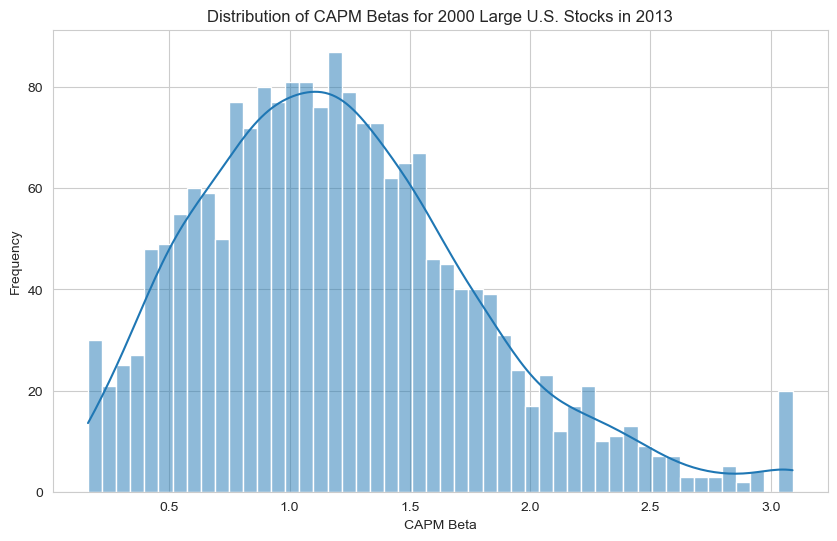

In [ ]:
# CRSP's corporate finance data 2000 large U.S. stocks in 2013
crsp = pd.read_excel('data/crsp_corp_fin_2013.xlsx').set_index('ticker')
crsp['Return2013'] *= 100 # convert to percentage
display(crsp.head())

# Let's look at the distribution of betas
plt.figure(figsize=(10,6))
sns.histplot(crsp['Beta'], bins=50, kde=True)
plt.title('Distribution of CAPM Betas for 2000 Large U.S. Stocks in 2013')
plt.xlabel('CAPM Beta')
plt.ylabel('Frequency')
plt.show()

#### (6.3) Intepretation of Betas
1. Which stocks have the highest Betas? What does it mean?

<span style="color:red">These stocks have the highest systematic risk, most likely driven by industry cyclicality. For example, \$CAR, a rental car platform, sells a leisure good; when the market is doing well, more people go on vacation, but in a recession, who is buying a rental car?</span>

In [ ]:
# Which stocks have the highest betas?
# Add company names (I cheated and knew the answers already, so working backwards)
high_beta_firms = {
    'Ticker': ['CAR', 'CENX', 'CETV', 'DNDN', 'EVC'],
    'Company': [
        'Avis Budget Group, Inc.',
        'Century Aluminum Company',
        'Central European Media Enterprises Ltd.',
        'Dendreon Corporation',
        'Entravision Communications Corporation'
    ]
}
beta_df = pd.DataFrame(high_beta_firms).set_index('Ticker')
beta_df['Beta'] = crsp['Beta'].nlargest(5)
print('Firms with the highest Betas in 2013:')
display(beta_df)

Firms with the highest Betas in 2013:


,Company,Beta
Ticker,,
CAR,"Avis Budget Group, Inc.",3.09119
CENX,Century Aluminum Company,3.09119
CETV,Central European Media Enterprises Ltd.,3.09119
DNDN,Dendreon Corporation,3.09119
EVC,Entravision Communications Corporation,3.09119


#### (6.4) Predicting Returns with CAPM
Conduct the following analysis:
1. Using the average expected market return from the investment banks, compute the expected return for each stock
2. Compare the predicted returns to the realized returns in 2013

,Beta,Return2013,CAPM_Return2013
ticker,,,
A,1.43143,30.075869,9.948438
AA,2.00463,92.423286,13.932179
AAON,0.94210,43.886277,6.547595
AAP,0.50153,4.913747,3.485634
AAPL,1.16929,49.002307,8.126565


Corr(CAPM Predicted Returns, Realized Returns): -0.77%


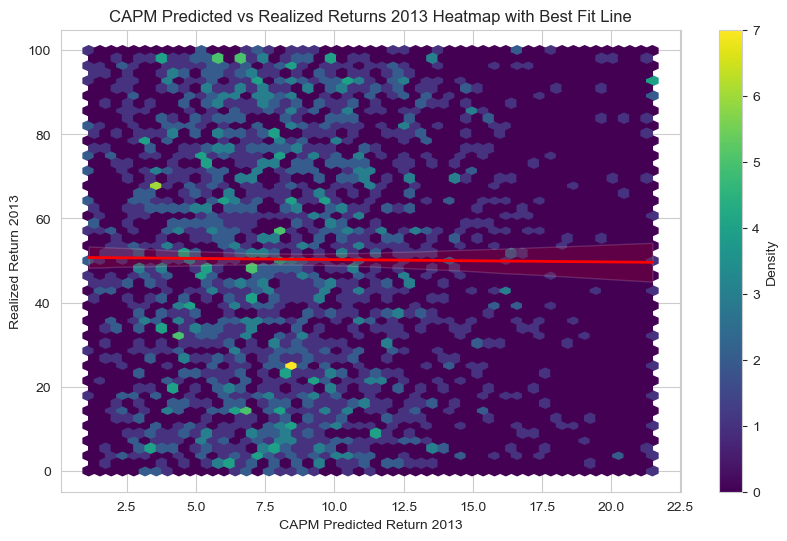

In [ ]:
# 1. Compute expected return for each stock using CAPM
crsp_returns = crsp[['Beta', 'Return2013']].copy()
crsp_returns['CAPM_Return2013'] = crsp_returns['Beta'] * exp_market_return
display(crsp_returns.head())

# Print correlation between predicted and realized returns
correlation = crsp_returns[['CAPM_Return2013', 'Return2013']].corr().iloc[0,1]
print(f'Corr(CAPM Predicted Returns, Realized Returns): {correlation:.2%}')

# 2. Compare predicted returns to realized returns in 2013
# Use heatmap since too many points, group into hexagonal bins
plt.figure(figsize=(10,6))
hb = plt.hexbin(
    crsp_returns['CAPM_Return2013'],
    crsp_returns['Return2013'],
    gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Density')
# Add regression line
sns.regplot(
    x='CAPM_Return2013', y='Return2013',
    data=crsp_returns, scatter=False,
    line_kws={"color": "red", "lw": 2})
plt.xlabel('CAPM Predicted Return 2013')
plt.ylabel('Realized Return 2013')
plt.title('CAPM Predicted vs Realized Returns 2013 Heatmap with Best Fit Line')
plt.show()

#### (6.5) How did the CAPM perform?

<span style="color:red">**This is not a valid method of testing the CAPM.**</span> Here are a few of the (many) problems:
   1. Small sample size (more on this later). CAPM's empirical validity holds in the long run, not necessarily in short horizons like a single year. A single-year cross-section of returns lacks the sample size and statistical power to robustly test the model.
   2. Stock returns exhibit high volatility and idiosyncratic noise (stemming from luck, market microstructure, and varying investor behavior), making it difficult to isolate the systematic component predicted by CAPM. **CAPM predicts expected returns, but realized returns can deviate significantly in small samples due to random fluctuations**, just as a fair coin can come up heads or tails multiple times in a row (*this does not mean the coin is rigged*). **This is why Fama, French construct industry portfolios to test the CAPM.**

Here's the statistical equivalent of CAPM on single-year returns (or small samples):
   * Consider three stocks with normally-distributed returns $\sim N(\mu, \sigma^2)$: (0.05, 0.04), (0.08, 0.03), (0.11, 0.05).
   * The returns have different means and variances, but there is a lot of overlap between them
   * In a single draw from each distribution, it is quite possible that the draw from the lowest-mean distribution is higher than the draw from the highest-mean distribution.

CAPM makes a statement about **expected excess return**, but the high variance of stock returns (particularly idiosyncratic risk) makes it difficult to observe the expected return ordering predicted by CAPM in a single year. **Use the Time-Series, Cross-Sectional regressions to formally test CAPM (and other factor models)!**

Stock 1: Sample=7.59%
Stock 2: Sample=9.73%
Stock 3: Sample=4.35%


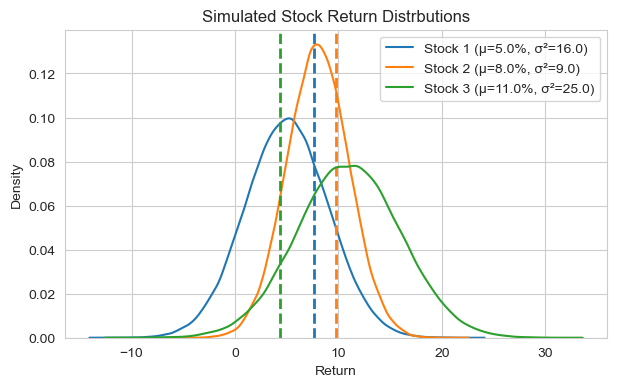

In [ ]:
# Simulate three normal distributions with different means and variances
np.random.seed(42)
dist_params = [(5, 16), (8, 9), (11, 25)]
samples = [np.random.normal(mu, np.sqrt(var), 100000) for mu, var in dist_params]

# Print single sample from each distribution
single_samples = [sample[2] for sample in samples]
for i, (mu, var) in enumerate(dist_params):
    print(f'Stock {i+1}: Sample={single_samples[i]:.2f}%')

# Plot the distributions, marking the single draws...
palette = sns.color_palette("tab10", n_colors=len(samples))
plt.figure(figsize=(7,4))
for i, sample in enumerate(samples):
    color = palette[i]
    sns.kdeplot(sample, label=f'Stock {i+1} (μ={dist_params[i][0]:.1f}%, σ²={dist_params[i][1]:.1f})', color=color)
    plt.axvline(single_samples[i], linestyle='--', color=color, lw=2)
plt.title('Simulated Stock Return Distrbutions')
plt.xlabel('Return'); plt.ylabel('Density'); plt.legend(); plt.show()

### (6.6) How much data do you need to test CAPM?

Check out the following table from Lo and MacKinlay (1990) the relationship between sample size ($T$, months), number of assets ($N$), and probability of rejecting the null hypothesis that $\alpha^i = 0$ for all assets $i$ ($H_0 : \mathbf{\alpha} = 0$). Prior to Gibbons, Ross, Shanken (1989), the Wald test statistic $J_0$ was used to jointly test the null hypotheses (*note that we have $N$ null hypotheses*). While asymptotically valid, GRS showed that $J_0$ has poor finite-sample properties and worked out the actual finite-sample distribution of the F-test statistic $J_1$.

$$
J_0 = T \left[ 1 + \frac{\hat{\mu}^2_m}{\hat{\sigma}^2_m} \right]^{-1} 
\hat{\alpha}' \hat{\Sigma}^{-1} \hat{\alpha}
$$

$$
J_1 = \frac{T - N - 1}{N} J_0
$$

Each tabular entry adjusts the asymptotic 5\% probability of correctly rejecting the null hypothesis to the specified sample size and number of assets. For example, the first entry indicates that for $N=10$ assets and $T=60$ months of data, the actual probability of rejecting the null hypothesis is 17.0\% when using the Wald test statistic. Thus, $J_0$ rejects the null hypothesis more than three times as often as it should! Note that $J_2, J_3$ statistics are modificatiosn of $J_1$ that further improves finite-sample properties.

Notes
- As number of assets \$ N \$ increase, the problem gets worse.
- For \$ N = 40 \$, \$ T = 60 $, the actual rejection rate is 98.5% ($ J_0 $) and 80.5% ($ J_2 \$).
- Even when \$ N = 40 \$, the 5% test is still overstated by more than 3x, even with \$ N = 360 \$.

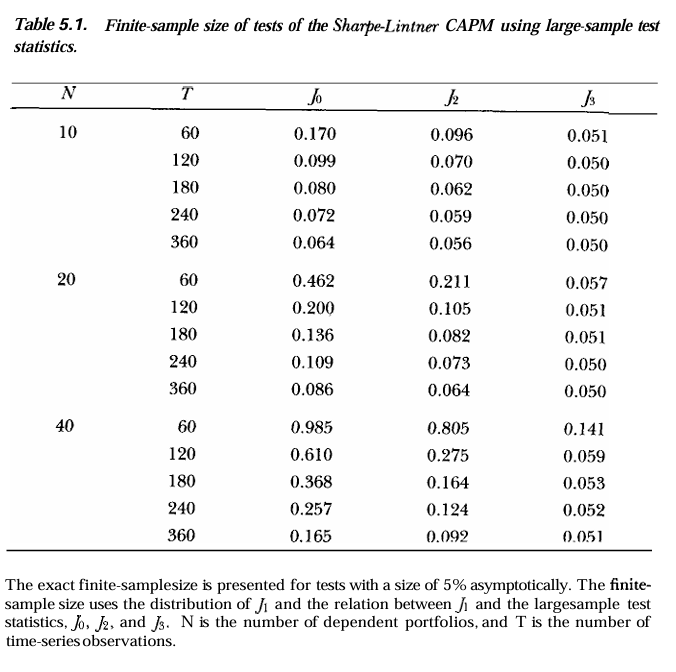

In [ ]:
display(Image(filename="pictures/lo_test_power.png"))

### (7.1) *THEORETICAL APPLICATION OF CAPM: Why do stocks become more correlated during financial crises?*

*Stylized fact*: During market downturns, correlations among stocks tend to increase, leading to a phenomenon known as "correlation breakdown" or "flight to quality." Thus, you might have a well-diversified portfolio in periods of low market volatility, but when market volatility spikes, your portfolio might not be as diversified as you think! *(Recall from September Launch w/ Mark)*

Consider Walmart (WMT) and Microsoft (MSFT). During normal market conditions, these two stocks may exhibit low correlation due to their different business models and customer bases. However, during a financial crisis, both stocks may experience increased selling pressure as investors seek to reduce risk, leading to a spike in their correlation.

Consider this data:
   * Walmart (WMT), Microsoft (MSFT), Eli Lilly \& Co. (LLY), IBM (IBM), Home Depot (HD)
   * Daily returns (%) from 1/1/1995 - 12/31/2024

In [ ]:
# Import CRSP data
stock_raw = pd.read_csv('data/crsp_stock_data_1995.csv')

# Clean: pivot wider, set date-time index, consider NAs
stock_raw['date'] = pd.to_datetime(stock_raw['date'])
stock_raw['RET'] = pd.to_numeric(stock_raw['RET'], errors='coerce')
stocks = stock_raw.pivot(index='date', columns='TICKER', values='RET')
stocks = stocks.sort_index().dropna(how='all')
stocks.index.name = 'date'
stocks.drop(columns=['GOOG', 'GOOGL'], inplace=True)
display(stocks.head())

stocks[['MSFT']].to_csv("data/msft.csv")

TICKER,HD,IBM,LLY,MSFT,WMT
date,,,,,
1995-01-03,-0.013587,0.003401,-0.005714,-0.015337,-0.017647
1995-01-04,-0.005510,0.008475,-0.001916,0.007269,0.035928
1995-01-05,-0.005540,-0.005042,0.003839,-0.016495,0.011561
1995-01-06,-0.002786,0.015203,-0.003824,0.016771,0.005714
1995-01-09,0.013966,0.004992,-0.005758,-0.006186,-0.005682


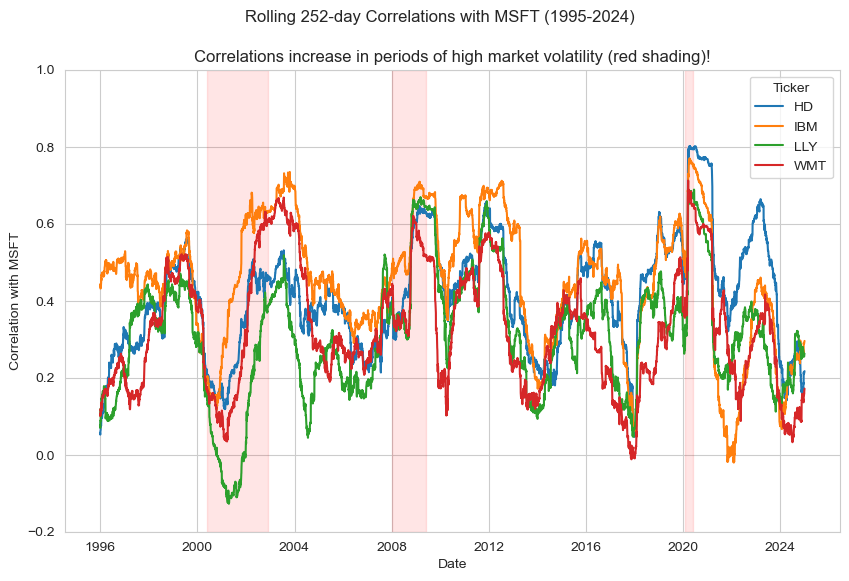

In [ ]:
# Calculate rolling correlations b/n each stock and MSFT
rolling_window = 252  # approx. 6 months of trading days
rolling_corrs = stocks.rolling(window=rolling_window).corr(stocks['MSFT'])
rolling_corrs = rolling_corrs.drop(columns=['MSFT'])  # drop self-correlation

# Plot rolling correlations
# Define datafame of market downturns
market_stress = pd.DataFrame(data = {'start' : pd.to_datetime(['2000-06-01', '2007-12-31', '2020-02-01']),
                                     'end'   : pd.to_datetime(['2002-12-01', '2009-06-01', '2020-06-01'])},
                             index = ['Dot-com Bubble', 'Global Financial Crisis', 'COVID-19 Crash'])

# Plot rolling correlations, shade market downturns
plt.figure(figsize=(10,6))
for ticker in rolling_corrs.columns:
    plt.plot(rolling_corrs.index, rolling_corrs[ticker], label=ticker)
for period in market_stress.itertuples():
    plt.axvspan(period.start, period.end, color='red', alpha=0.1)
plt.suptitle(f'Rolling {rolling_window}-day Correlations with MSFT (1995-2024)')
plt.title('Correlations increase in periods of high market volatility (red shading)!')
plt.ylabel('Correlation with MSFT'); plt.xlabel('Date')
plt.legend(title='Ticker'); plt.ylim(-0.2, 1); plt.show()

### (7.2) Can CAPM explain why pairwise asset correlations increase during market distress?

*Yes!* Define market distress as a period of high market volatility. Consider the CAPM equation for two assets $i$ and $j$:
   \begin{align}
       \tilde{r}_{i,t} = \beta_i\tilde{r}_{m,t} + \varepsilon_i, &\, \quad \sigma_{i,t}^2 =\beta_i^2\sigma_{m,t}^2 +\nu_i\tag{Asset $i$}\\
       \tilde{r}_{j,t}= \beta_j\tilde{r}_{m,t} + \varepsilon_j, &\, \quad \sigma_{j,t}^2 =\beta_j^2\sigma_{m,t}^2 +\nu_j \tag{Asset $j$}
   \end{align}
   where $\sigma_{m,t}^2$ is the variance of the market portfolio, and $\nu_i = \text{var}(\varepsilon^i)$ and $\nu_j = \text{var}(\varepsilon^j)$ are the idiosyncratic risk components of assets $i$ and $j$, respectively. I introduce the $t$ subscripts to indicate that the returns and variances are time-varying.

   Now, let's consider the covariances between the two assets, assuming idiosyncratic risks are uncorrelated $\text{cov}(\varepsilon^i, \varepsilon^j) = 0$, we have:

   \begin{align}
       \text{cov}(\tilde{r}^i, \tilde{r}^j) &= \text{cov}(\beta_i\tilde{r}_{m,t} + \varepsilon_i,\beta_j\tilde{r}_{m,t} + \varepsilon_j)\\
       &= \beta_i \beta_j \sigma_{m,t}^2 + \beta_i \operatorname{cov}(\tilde{r}_{m,t}, \varepsilon_j) + \beta_j \operatorname{cov}(\varepsilon_i, \tilde{r}_{m,t}) + \operatorname{cov}(\varepsilon_i, \varepsilon_j) \tag{Expand}\\
       &= \beta_i\beta_j\sigma_{m,t}^2 \tag{Much cancellation!}\\
       \rho_{i,j} &= \frac{\beta_i\beta_j\sigma_{m,t}^2}{\sqrt{(\beta_i^2\sigma_{m,t}^2 +\nu_i)(\beta_j^2\sigma_{m,t}^2 +\nu_j)}} \tag{5.1}
   \end{align}
Correlation between assets is proportional to the market portfolio's variance $(\sigma_{m,t}^2)$. Assuming both $\beta$'s are positive:
   * For low market volatility, the idiosyncratic terms dominate.
   * For high market volatility, market-wide shocks overwhelm idiosyncratic noise, and assets move together, increasing correlation.

### (7.3) Empirical Example
Empirically, let's observe this trend in our simple model:
1. Estimate market volatility using the daily returns of SPX.
    1. I fit a GARCH(1,1) model with Student's t distribution for the residuals.
    2. Normal distribution of residuals underestimates extreme events (fat tails) for financial returns.
2. Use the estimated beta's from CRSP data.
3. Estimate the variance of the idiosyncratic risk for each stock.
4. Plot the theoretical correlation using the equation (5.1). The plot should resemble the rolling correlations we observed earlier.

#### (7.3.1) Estimate Market Volatility

To estimate the volatility of the market, I fit a GARCH model to the SPX. Recall GARCH equation from lecture (2):
$$\sigma^2_{m,t} = \alpha + \gamma\sigma^2_{m,t-1} + \delta r^2_{m,t-1}$$
where volatility is a function of past squared returns (news/ innovations) and past volatility:

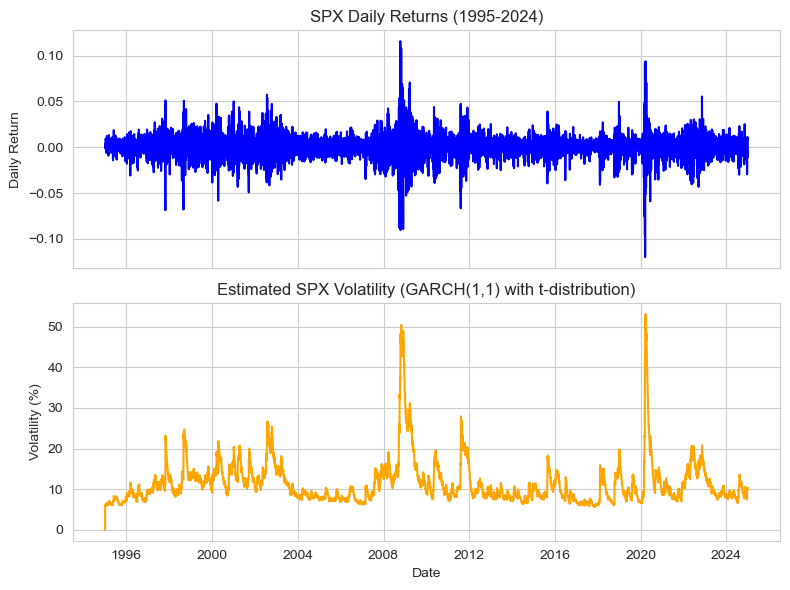

In [ ]:
# 1. Fit market volatility using a rolling window
# A) Import SPX return data
spx_data = pd.read_csv('data/spx_ret_1995.csv')
spx_data['date'] = pd.to_datetime(spx_data['date'])
spx_data = spx_data.set_index('date').sort_index()

# B) Fit GARCH model to SPX returns to estimate time-varying volatility
model = arch_model(spx_data['spx'], vol='GARCH', p=1, q=1, dist='t')
res = model.fit(disp='off')
spx_data['sigma_m'] = res.conditional_volatility # extract the fitted values (volatility, not variance)

# C) Compare SPX returns and estimated volatility... looks good!
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax[0].plot(spx_data.index, spx_data['spx'], color='blue')
ax[0].set_title('SPX Daily Returns (1995-2024)')
ax[0].set_ylabel('Daily Return')
ax[1].plot(spx_data.index, spx_data['sigma_m'], color='orange')
ax[1].set_title('Estimated SPX Volatility (GARCH(1,1) with t-distribution)')
ax[1].set_ylabel('Volatility (%)'); ax[1].set_xlabel('Date')
plt.tight_layout(); plt.show()

#### (7.3.2) Load Beta Estimates from CRSP

From the previously discussed CRSP data, we can extract the CAPM beta estimates for our stocks of interest. Let's use the 2013 beta estimates for our analysis. *Is it reasonable to assume that betas are constant over time?*

In [ ]:
# Obtained from CRSP data for 2013
select_betas = pd.Series(data = {'WMT':0.312, 'MSFT': 0.906, 'LLY': 0.653, 'IBM': 0.645, 'HD': 0.687}, name = 'beta')
print(select_betas)

WMT     0.312
MSFT    0.906
LLY     0.653
IBM     0.645
HD      0.687
Name: beta, dtype: float64


#### (7.3.3) Estimate Variance of Idiosyncratic Risk (firm-level risk)
To estimate the idiosyncratic risk variance for each stock, we fit a CAPM regression using SPX returns as the market factor:
   $$r_{i,t} = \alpha_i + \beta_i r^m_t + \varepsilon_{i,t}$$
The variance of the residuals $\varepsilon_{i,t}$ provides an estimate of the idiosyncratic risk variance $\nu_i$ for each stock.

Note that the idiosyncratic (firm-specific) residuals should be uncorrelated across stocks by definition. Additionally, we used this assumption in the derivation of equation (5.1), so it's important to verify it empirically.

Idiosyncratic residual variances:
HD      0.014512
IBM     0.013649
LLY     0.015610
MSFT    0.014239
WMT     0.013622
dtype: float64


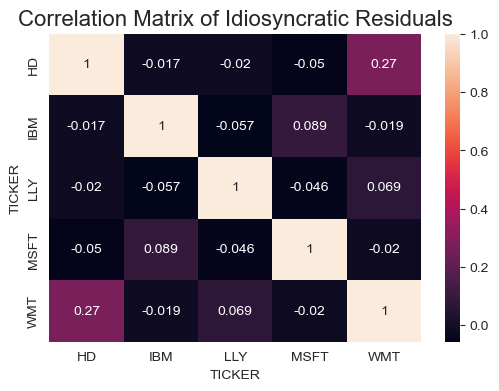

In [ ]:
# 2. Estimate idiosyncratic risk variance for each stock
idiosyncratic_vars, idiosyncratic_resids = {}, pd.DataFrame(columns = stocks.columns)
for ticker in stocks.columns:
    Y = stocks[ticker].dropna()
    X = spx_data['spx'].reindex(Y.index).dropna()
    Y = Y.reindex(X.index)
    X = sm.add_constant(X)  # add intercept
    model = sm.OLS(Y, X).fit()
    idiosyncratic_resids[ticker] = model.resid
    idiosyncratic_vars[ticker] = np.std(idiosyncratic_resids[ticker]) # use vols instead of variances... why?
idiosyncratic_vars = pd.Series(idiosyncratic_vars)
print(f'Idiosyncratic residual variances:\n{idiosyncratic_vars}')
# correlation of idiosyncratic residuals
correlation_matrix = idiosyncratic_resids.corr()
fig, ax = plt.subplots(figsize=(6,4))
heatmap = sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns,
    annot=True)
heatmap.set_title('Correlation Matrix of Idiosyncratic Residuals', fontsize=16); plt.show()

#### (7.3.4) How does the theoretical correlation compare to the rolling correlations we observed earlier?
Now, we can compute the theoretical correlations between MSFT and each stock using equation (5.1):

$$
\rho_{i,j} = 
\frac{\beta_i \beta_j \sigma_{m,t}^2}{
\sqrt{(\beta_i^2 \sigma_{m,t}^2 + \nu_i)
(\beta_j^2 \sigma_{m,t}^2 + \nu_j)}}
$$

$$
\rho_{i,MSFT} =
\frac{\beta_i \beta_{MSFT} \sigma_{m,t}^2}{
\sqrt{(\beta_i^2 \sigma_{m,t}^2 + \nu_i)
(\beta_{MSFT}^2 \sigma_{m,t}^2 + \nu_{MSFT})}}
$$

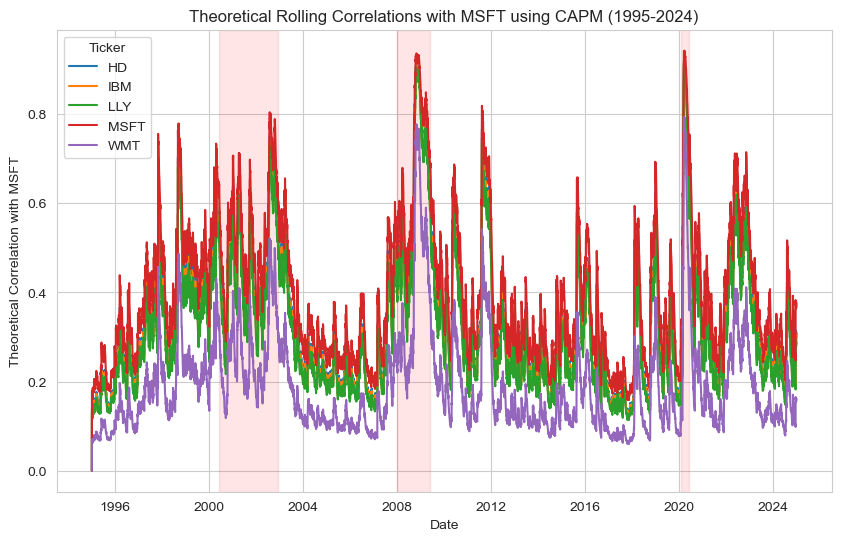

In [ ]:
# Implement equation (MSFT case) to compute theoretical correlations
theoretical_msft_corrs = pd.DataFrame(index=stocks.index, columns=stocks.columns)
# Calculate theoretical correlations using CAPM equation (5.1)
garch_mkt_var = (spx_data['sigma_m']/100) ** 2 # market variance from GARCH model
for i in stocks.columns:
    beta_i = select_betas[i] # beta of stock i
    beta_msft = select_betas['MSFT']
    nu_i = idiosyncratic_vars[i] # idiosyncratic variance of stock i
    nu_msft = idiosyncratic_vars['MSFT']
    theoretical_msft_corrs[i] = (beta_i * beta_msft * garch_mkt_var) / np.sqrt(
        (beta_i**2 * garch_mkt_var + nu_i) * (beta_msft**2 * garch_mkt_var + nu_msft)
    )

# Plot theoretical correlations
plt.figure(figsize=(10,6))
for ticker in theoretical_msft_corrs.columns:
    plt.plot(theoretical_msft_corrs.index, theoretical_msft_corrs[ticker], label=ticker)
for period in market_stress.itertuples():
    plt.axvspan(period.start, period.end, color='red', alpha=0.1)
plt.title(f'Theoretical Rolling Correlations with MSFT using CAPM (1995-2024)')
plt.ylabel('Theoretical Correlation with MSFT'); plt.xlabel('Date')
plt.legend(title='Ticker'); plt.show()